In [40]:
import os, sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm

%pylab inline

import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [41]:
train_path = glob.glob('./dataset/FWreID/bounding_box_train/*')
train_label = [int(x.split('/')[-1].split('_')[0]) for x in train_path]

In [42]:
len(train_label)

1358

In [43]:
!ls ./dataset/FWreID/query/ | wc -l

184


In [44]:
max(train_label)

190

In [45]:
pd.read_csv('example.csv').shape, pd.read_csv('submit.csv').shape

((183, 1512), (183, 1512))

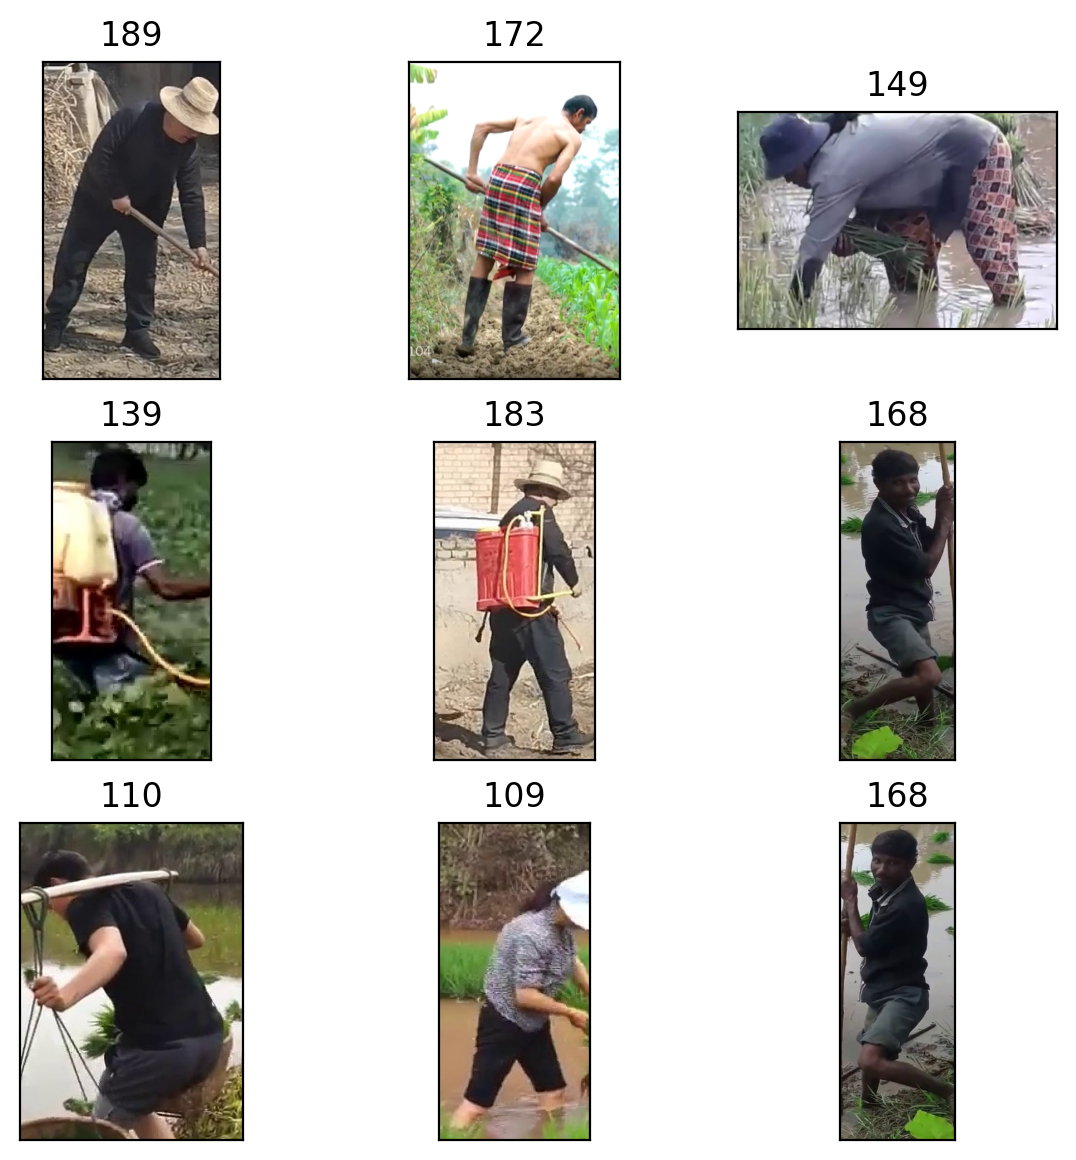

In [46]:
plt.figure(figsize=(7, 7), dpi=200)
for idx in range(9):
    plt.subplot(3, 3, idx+1)
    plt.imshow(Image.open(train_path[idx]))
    plt.xticks([]);
    plt.yticks([]);
    plt.title(train_label[idx])

In [47]:
DATA_CACHE = {}
class XunFeiDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    def __getitem__(self, index):
        if self.img_path[index] in DATA_CACHE:
            img = DATA_CACHE[self.img_path[index]]
        else:
            img = cv2.imread(self.img_path[index])
            DATA_CACHE[self.img_path[index]] = img
        if self.transform is not None:
            img = self.transform(image = img)['image']
        img = img.transpose([2,0,1])
        return img, torch.from_numpy(np.array(self.img_label[index]))
    def __len__(self):
        return len(self.img_path)

In [53]:
class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()
        model = models.resnet50(True)
        model.avgpool = nn.AdaptiveAvgPool2d(1)
        model.fc = nn.Linear(2048, 191)
        self.resnet = model
    def forward(self, img):
        out = self.resnet(img)
        return out

In [54]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('Train loss', loss.item())
            
        train_loss += loss.item()
    
    return train_loss/len(train_loader)
            
def validate(val_loader, model, criterion):
    model.eval()
    
    val_acc = 0.0
    
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)
            
            val_acc += (output.argmax(1) == target).sum().item()
            
    return val_acc / len(val_loader.dataset)

def predict(test_loader, model, criterion):
    model.eval()
    val_acc = 0.0
    
    test_pred = []
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(test_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            test_pred.append(output.data.cpu().numpy())
            
    return np.vstack(test_pred)

In [55]:
import albumentations as A
train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[:-100], train_label[:-100],
            A.Compose([
            A.Resize(256, 128),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    ), batch_size=30, shuffle=True, num_workers=1, pin_memory=False
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[-100:], train_label[-100:],
            A.Compose([
            A.Resize(256, 128),
            # A.HorizontalFlip(p=0.5),
            # A.RandomContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    ), batch_size=30, shuffle=False, num_workers=1, pin_memory=False
)

In [56]:
for data, lable in train_loader:
    break

In [57]:
model = XunFeiNet()
model = model.to('cuda')
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.AdamW(model.parameters(), 0.001)

/home/lyz/anaconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/lyz/anaconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/lyz/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 10.3MB/s]


In [58]:
for _  in range(8):
    train_loss = train(train_loader, model, criterion, optimizer)
    val_acc  = validate(val_loader, model, criterion)
    train_acc = validate(train_loader, model, criterion)
    
    print(train_loss, train_acc, val_acc)

Train loss 5.178513526916504
3.4557511664572216 0.27821939586645467 0.28
Train loss 1.6722967624664307
1.1295993462914513 0.5707472178060413 0.51
Train loss 0.4343225657939911
0.44657340752226965 0.9411764705882353 0.91
Train loss 0.20115868747234344
0.27962091884442736 0.9038155802861685 0.86
Train loss 0.22670011222362518
0.1825865882315806 0.9769475357710652 0.96
Train loss 0.08459056168794632
0.1387669760290356 0.9888712241653418 0.99
Train loss 0.06725917011499405
0.0768723141712447 0.980127186009539 0.98
Train loss 0.3452519476413727
0.14956978810507626 0.9213036565977742 0.89


In [60]:
model.fc = nn.Identity()

test_path = glob.glob('./dataset/FWreID/bounding_box_test/*')
test_path.sort()
test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_path[:], [0] * len(test_path),
            A.Compose([
            A.Resize(256, 128),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    ), batch_size=30, shuffle=False, num_workers=1, pin_memory=False
)

test_pred = predict(test_loader, model, criterion)

In [61]:
query_path = glob.glob('./dataset/FWreID/query/*')
query_path.sort()
query_loader = torch.utils.data.DataLoader(
    XunFeiDataset(query_path[:], [0] * len(query_path),
            A.Compose([
            A.Resize(256, 128),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    ), batch_size=30, shuffle=False, num_workers=1, pin_memory=False
)

query_pred = predict(query_loader, model, criterion)

In [62]:
test_pred.shape, query_pred.shape

((1512, 191), (184, 191))

In [63]:
from sklearn.preprocessing import normalize

test_pred = normalize(test_pred)
query_pred = normalize(query_pred)

In [64]:
ids = np.dot(query_pred, test_pred.T)

In [65]:
test_path = [int(x.split('/')[-1][:-4]) for x in test_path]

In [66]:
submit = pd.DataFrame([np.array(test_path)[x.argsort()[::-1]] for x in ids])

In [67]:
submit.to_csv('submit.csv', index=None, header=None)